## High-Value Customer Classification ##

Using the AdventureWorks 2019 database, can we predict how much revenue will be generated by each new customer before they make a purchase (based solely on their demographic information)? To do this we will define the customer base as regular or high-value and implement a classification model that aims to predict which class a customer belongs to.

## Data Sourcing ##

Since the dataset is large we will import it into the notebook using a connection to the SQL Server Database with a query developed in SQL Server ( see hv-query.sql). The query extracts the demographic information about each individual customer along with their total purchases. 

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#server and database names are stored in a separate file
with open("connect.json") as f:
    db_info = json.load(f)


connection_string = "DRIVER={ODBC Driver 17 for SQL Server};SERVER="+db_info["server"]+";DATABASE="+db_info["database"]+";Trusted_Connection=YES"

connection_url = sqlalchemy.engine.URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

conn = sqlalchemy.create_engine(connection_url)


# load query developed in ssms
with open("hv-query.sql", "r") as f:
    query = f.read()


df = pd.read_sql_query(query, conn)


df.head()



,BirthYear,MaritalStatus,Education,YearlyIncome,Gender,TotalChildren,Occupation,CommuteDistance,NumberCarsOwned,HomeOwnerFlag,TerritoryID,Total_Purchases
0,1943,M,Bachelors,25001-50000,M,1,Clerical,0-1 Miles,0,1,10,3481.1901
1,1968,M,Bachelors,50001-75000,M,2,Professional,2-5 Miles,1,1,9,5893.2413
2,1955,M,Partial College,greater than 100000,F,3,Professional,5-10 Miles,3,1,10,3308.4676
3,1968,S,Bachelors,50001-75000,F,2,Skilled Manual,0-1 Miles,1,0,4,1934.8329
4,1979,M,Partial College,0-25000,M,0,Manual,2-5 Miles,1,1,9,71.2394


## Data Exploration + Cleaning ##

Let's do some basic exploration of the data to to make sure everything is set up for modeling

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BirthYear        18484 non-null  int64  
 1   MaritalStatus    18484 non-null  object 
 2   Education        18484 non-null  object 
 3   YearlyIncome     18484 non-null  object 
 4   Gender           18484 non-null  object 
 5   TotalChildren    18484 non-null  int64  
 6   Occupation       18484 non-null  object 
 7   CommuteDistance  18484 non-null  object 
 8   NumberCarsOwned  18484 non-null  int64  
 9   HomeOwnerFlag    18484 non-null  object 
 10  TerritoryID      18484 non-null  int64  
 11  Total_Purchases  18484 non-null  float64
dtypes: float64(1), int64(4), object(7)
memory usage: 1.7+ MB


In [3]:
df.isna().sum()

BirthYear          0
MaritalStatus      0
Education          0
YearlyIncome       0
Gender             0
TotalChildren      0
Occupation         0
CommuteDistance    0
NumberCarsOwned    0
HomeOwnerFlag      0
TerritoryID        0
Total_Purchases    0
dtype: int64

In [4]:
df.describe()

,BirthYear,TotalChildren,NumberCarsOwned,TerritoryID,Total_Purchases
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,1961.579961,1.844352,1.502705,5.898399,1755.103826
std,11.249188,1.612408,1.138394,3.061200,2347.276065
min,1910.000000,0.000000,0.000000,1.000000,2.530500
25%,1954.000000,0.000000,1.000000,4.000000,55.216900
50%,1963.000000,2.000000,2.000000,6.000000,298.643000
75%,1970.000000,3.000000,2.000000,9.000000,2774.958950
max,1980.000000,5.000000,4.000000,10.000000,14691.395000


It is concerning that there were customers born as early as 1910 given the database references data between 2011-2014. Though this isn't impossible it could be an error in entry: lets limit the customers to those born 70 years or less before the database converage dates (2011-70 = 1941)

In [5]:
df.drop(df[df.BirthYear < 1941].index, inplace=True)

array([[<Axes: title={'center': 'Total_Purchases'}>]], dtype=object)

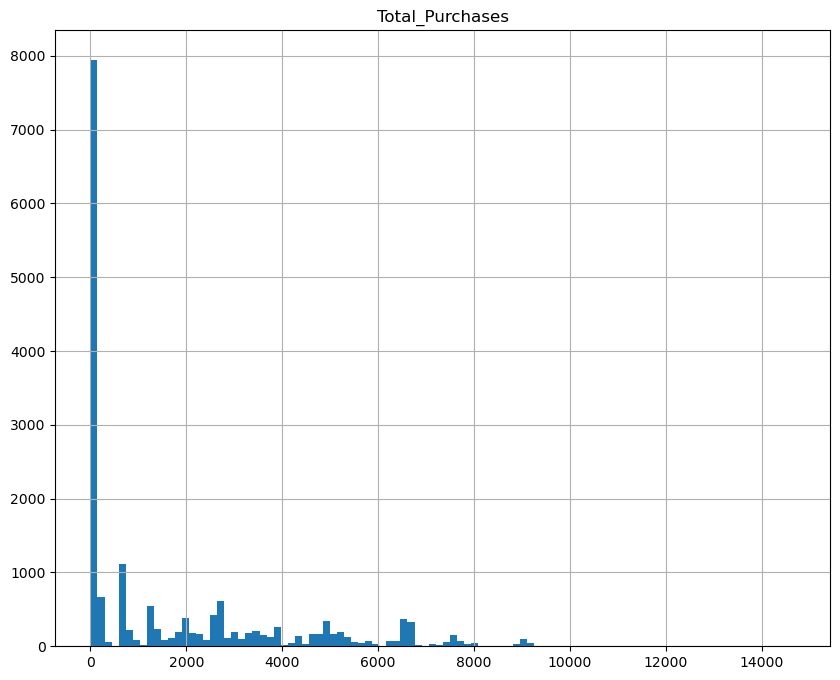

In [6]:
df.hist(column='Total_Purchases',bins=100,figsize=(10,8))

There's a large amount of customers (roughly half) that have a lifetime purchase amount less than $500 . There are likely man factors that go into this total such as products purchased and the duration an individual has been a customer, but let's see how well these two classes of customer (regular and high-value) may be predicted with information entirely independent of their purchase history. 

## Preprocessing + Feature Engineering ##

First create a new binary target variable indicating high-value or not. Then we must create a preprocessing pipeline to be applied to the data. There are categorical features that may be OneHotEncoded and those that require some feature engineering (such as commute distance) to preserve the relative distances between intervals.



In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#create a binary target variable
df["HighValue"] = ""
df.loc[df['Total_Purchases'] >= 500, 'HighValue'] = int(1)
df.loc[df['Total_Purchases'] < 500, 'HighValue'] = int(0)


# encode the commute distance intervals to be the ranges halfway mark, then scale to [0,1]
class CommuteEncoder(BaseEstimator, TransformerMixin):
    def __init__(self): 
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):

        X.loc[X['CommuteDistance'] == '0-1 Miles', 'CommuteDistance'] = 0.5
        X.loc[X['CommuteDistance'] == '1-2 Miles', 'CommuteDistance'] = 1.5
        X.loc[X['CommuteDistance'] == '2-5 Miles', 'CommuteDistance'] = 3.5
        X.loc[X['CommuteDistance'] == '5-10 Miles', 'CommuteDistance'] = 7.5
        X.loc[X['CommuteDistance'] == '10+ Miles', 'CommuteDistance'] = 15.0 #or some other suitable choice

        X_norm = MinMaxScaler().fit_transform(X)

        return X_norm
    

    def get_feature_names_out(self, feature_names_out):
        return ['CommuteDistance']
    


categorical_features = ['Education','Occupation','TerritoryID','MaritalStatus','Gender', 'HomeOwnerFlag']

ordinal_features = ['YearlyIncome',]
ordinal_sequence = [['0-25000','25001-50000','50001-75000','75001-100000','greater than 100000']]

numeric_feat = ['BirthYear','TotalChildren','NumberCarsOwned']



preprocessor = ColumnTransformer([
    ('OneHotEncode', OneHotEncoder(drop ='if_binary', handle_unknown='ignore'), categorical_features),
    ('Scale', MinMaxScaler(), numeric_feat),
    ('DistEncode', CommuteEncoder(), ['CommuteDistance']),
    # scale after encoding to keep ranges consistent
    ('OrdinalEncode', Pipeline([
        ('oe_stage1', OrdinalEncoder(categories = ordinal_sequence)),
        ('oe_stage2', MinMaxScaler()) 
        ]), ordinal_features  )
])

## Modeling ## 

We'll use a grid search across a couple models and hyperparameters to get an idea of our prediction cabability while retrieving the accuracy, precision, recall, and AUC. The final model will be refitted in regards to the best performing AUC metric. 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV



X=df.drop(['Total_Purchases','HighValue'], axis=1)
y=df[['HighValue']]
y = LabelEncoder().fit_transform(y.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)



pipe = Pipeline([
    ('preprocess', preprocessor),
    ('estimator', None)
    ])


grid_params = [
    {
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': [4,5,6]
    },
    {
        'estimator': [RandomForestClassifier()],
        'estimator__max_depth' : [10,15],
        'estimator__n_estimators' : [100, 200]
    }
]

scoring = {
        'Accuracy':'accuracy',
        'Precision':'precision',
        'Recall':'recall',
        'AUC':'roc_auc'
        }


grid = GridSearchCV(pipe, grid_params, scoring = scoring, refit='AUC') 

grid.fit(X_train, y_train)

final_model = grid.best_estimator_

results = pd.DataFrame(grid.cv_results_)
pd.set_option('display.max_colwidth', 150)
results.sort_values('rank_test_AUC')[['params','mean_test_Accuracy','mean_test_Precision','mean_test_Recall','mean_test_AUC']]

,params,mean_test_Accuracy,mean_test_Precision,mean_test_Recall,mean_test_AUC
6,"{'estimator': RandomForestClassifier(max_depth=15, n_estimators=200), 'estimator__max_depth': 15, 'estimator__n_estimators': 200}",0.788845,0.786363,0.801418,0.863586
5,"{'estimator': RandomForestClassifier(max_depth=15, n_estimators=200), 'estimator__max_depth': 15, 'estimator__n_estimators': 100}",0.789179,0.786174,0.802558,0.863314
4,"{'estimator': RandomForestClassifier(max_depth=15, n_estimators=200), 'estimator__max_depth': 10, 'estimator__n_estimators': 200}",0.763093,0.757034,0.785082,0.835906
3,"{'estimator': RandomForestClassifier(max_depth=15, n_estimators=200), 'estimator__max_depth': 10, 'estimator__n_estimators': 100}",0.763827,0.757126,0.787086,0.834282
0,"{'estimator': KNeighborsClassifier(), 'estimator__n_neighbors': 4}",0.702449,0.760408,0.603460,0.772915
1,"{'estimator': KNeighborsClassifier(), 'estimator__n_neighbors': 5}",0.707519,0.711118,0.713020,0.771352
2,"{'estimator': KNeighborsClassifier(), 'estimator__n_neighbors': 6}",0.707518,0.747331,0.639869,0.771092


Sklearn output is slightly redundant when implementing multiple models in GridSearchCV but we can still see the best performing parameters.

## Evaluation and Postprocessing ##

accuracy:   0.7966742252456538
precision:  0.7842586085734364
recall:     0.8285077951002228
AUC:        0.8660948145252502


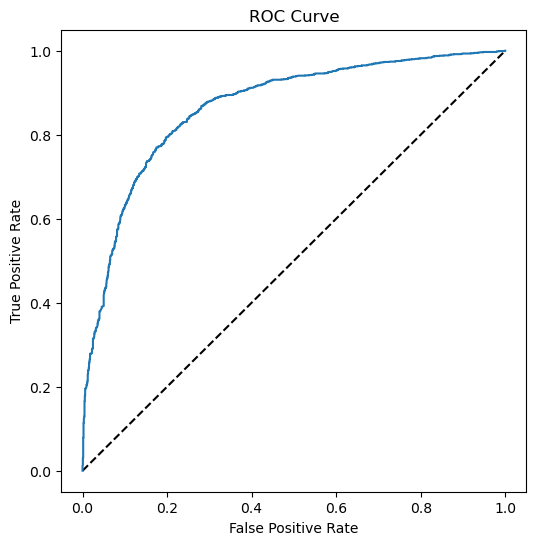

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

def eval_model(model, x_test, y_test):


    y_pred = model.predict(x_test).astype(int)

    acc = accuracy_score(y_test,y_pred)
    pres = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)

    auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])


    print("accuracy:  " , acc)
    print("precision: " , pres)
    print("recall:    " , rec)
    print("AUC:       " , auc)


    return


def plot_auc(model, X_test, y_test):

    y_pred = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    fig = plt.figure(figsize=(6,6))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    return




eval_model(final_model, X_test, y_test)
plot_auc(final_model, X_test, y_test)


Let's also look at which customer demographic features contribute most to prediction capability. Many of the variables are encoded for modelling, however it would be nice to see a measure of, for example, the total territory importance rather than each individual territory's importance. To achieve this we will find each sub-features importance and then total them to find a measure of the more general feature's importance.

<Axes: >

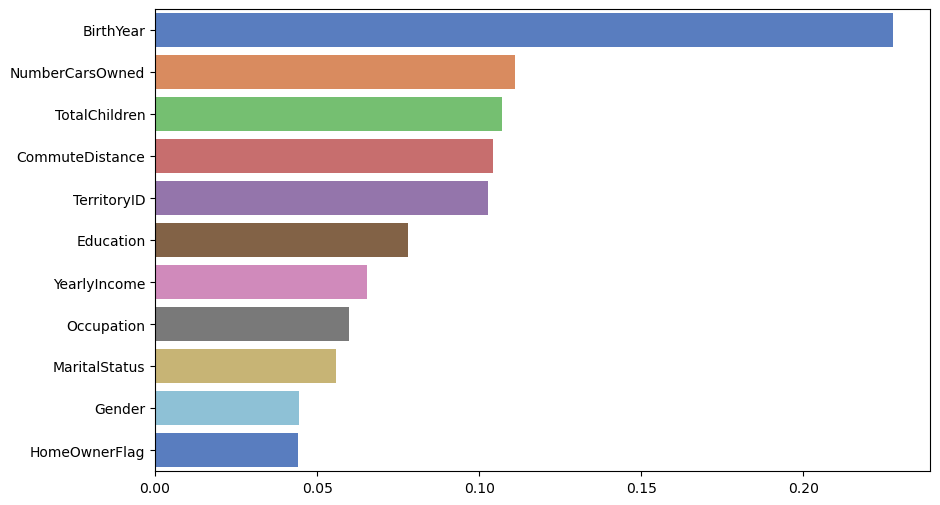

In [10]:
feat_importance = grid.best_estimator_.named_steps.estimator.feature_importances_.tolist()
labels = grid.best_estimator_.named_steps.preprocess.get_feature_names_out().tolist()

base_features = df.drop(['Total_Purchases', 'HighValue'], axis=1).columns.to_list()

base_importance_agg = [0]*len(base_features)

for feature in base_features:
        
    for sub_category in labels:
            
        if feature in sub_category:
                
            base_importance_agg[base_features.index(feature)] = base_importance_agg[base_features.index(feature)] + feat_importance[labels.index(sub_category)]




feature = labels + base_features
importance = feat_importance + base_importance_agg

final = list(zip(feature,importance))


final_importances = sorted(final,key=lambda x:x[1],reverse=True)

imp_df = pd.DataFrame(final_importances)
base_imp = imp_df[imp_df.iloc[:, 0].isin(base_features)].to_numpy()


# figure size in inches
rcParams['figure.figsize'] = 10,6

sns.barplot(y=base_imp[::,0],x=base_imp[::,1],orient='h',palette = "muted")

Insights:

- By far the largest predictor of a high-value customer is their age. 

- Several of the larger predictors make intuitive sense when considering an individuals ability to use a bike for commuting as opposed to purely recreation (Cars owned, children that need transport, commute distance, territory). 

- It is interesting that Yearly Income is relatively low in importance as one would assume more spending money would heavily influence total purchases. 


There is much more that could be analysed using this information as the feature importance indicates what the largest influencers are and not the 'direction' of their influence. Further breakdowns such as which age groups are most fall into the high-value cateogory and which territories correspond to cities, towns, suburbs, or rural areas would likely improve prediction capability and understanding. 
